In [1]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

In [2]:
# Parameters
WINDOW_SIZE = (224, 224) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 5 # Number of input channels (e.g. RGB)
FOLDER = "../input/potsdamvaihingen/" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 10 # Number of samples in a mini-batch

LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATASET = 'Potsdam'

if DATASET == 'Potsdam':
    MAIN_FOLDER = FOLDER
    DATA_FOLDER = MAIN_FOLDER + '3_ortho_irrg/3_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    DSM_FOLDER = MAIN_FOLDER + '1_dsm/1_DSM/dsm_potsdam_0{}.tif'
    NDSM_FOLDER = MAIN_FOLDER + '1_dsm_normalisation/1_DSM_normalisation/dsm_potsdam_0{}_normalized_lastools.jpg'
    LABEL_FOLDER = MAIN_FOLDER + '5_labels_for_participants/5_Labels_for_participants/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_labels_for_participants_no_boundary/5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'    

In [3]:
# ISPRS color palette
# Let's define the standard ISPRS color palette

palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

In [4]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [5]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x), dim=0)
        return x

In [6]:
# instantiate the network
net = SegNet()

In [7]:
net.load_state_dict(torch.load("../input/svgnet-2/segnet256_epoch100"))
net.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom

In [8]:
test_ids = [ '2_12', '3_11', '3_12', '5_12']
#'6_10', '7_9', '7_10','5_10', '2_11'

In [9]:
from IPython.display import clear_output
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.dstack((io.imread(DATA_FOLDER.format(id), dtype='float32'), io.imread(DSM_FOLDER.format(id)), 
                                 io.imread(NDSM_FOLDER.format(id)))) for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    #plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    #fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        #fig.add_subplot(1,3,1)
        #plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,1)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,2)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [10]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=224)

Confusion matrix :
[[5836793  236034 1032752  770806 1521467  995490]
 [ 508966 8662383 1976825 1521068 1768971 2649516]
 [ 120363   51704 1689358  621451  237488  177710]
 [  72612   20865  346162 1238834  159757  112137]
 [  28607    1859   26852   15072  746064   22585]
 [  36108   49928   72875   56008  236010  144570]]
---
33766050 pixels processed
Total accuracy : 54.24976270543934%
---
F1Score :
roads: 0.6868111751212331
buildings: 0.663517154898056
low veg.: 0.42008688907903596
trees: 0.4013323817554927
cars: 0.27076451387422074
clutter: 0.06155179758114251
---
Kappa: 0.4124704270902059
Confusion matrix :
[[19809603  3473410  2027765  1626905  4018488  4378487]
 [ 1728494 20106527  2697754  1877118  4619778  4159177]
 [ 1618518  5938719 18594754  5154871  2425925  4323626]
 [ 1314956  1015495  5179121 10327839  1636740  1500202]
 [   76579    73290    47367    34483  1589261    53540]
 [  235793   592733   300846   154878   764359   638390]]
---
134115791 pixels processed
Total

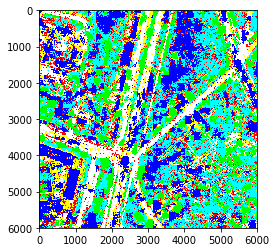

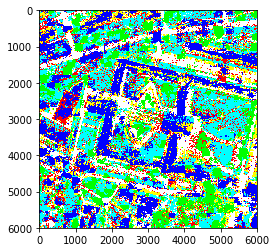

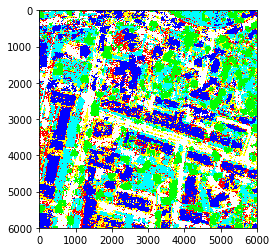

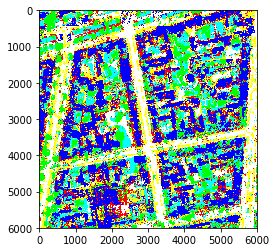

In [11]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./inference_tile_{}.png'.format(id_), img)